In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.constants as cst
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 14})
from scipy import interpolate
from symfit import parameters, variables, Model, Fit, exp
from symfit.core.minimizers import DifferentialEvolution, LBFGSB
import scipy.constants as cst


# USE SYMPY 1.6.2 (and  probably new environment)

# From Pressure to Tension

In [2]:
a = 5e-6 # Patch radius [m]
k = 0.24 # Area Compression modulus [N.m^-1]

In [3]:
def displacement_solver(Ps, a, k):
    """
        Find the displacement for a given applied Pressure
        
        Parameters
        ----------
        
        Ps : float
            Pressure attributed to the circumferential tension 
            per unit length in the membrane [Pa]
        a : float
                Patch radius  [m]
        k : float
            Area Compression modulus [N.m^-1]
    
        Returns
        -------
        Z : array
            Patch displacement [m]
        """
    params = [2*k,-Ps*a**2,0,-Ps*a**4]

    Z = np.roots(params)
    Z = Z[np.isreal(Z)].real

    return Z[0]


In [4]:
def set_R_curv(Z):
    R = (a**2 + Z**2) / (2*Z)
    return R

In [5]:
def set_tension(R,Ps):
    Ts = (R * Ps)

    return Ts 

In [6]:
Ps_mmHg = 15
Ps_PA = Ps_mmHg * 133.322 
Z_15mmHg = displacement_solver(Ps_PA,a,k)
R_curv = set_R_curv(Z_15mmHg)
Ts = set_tension(R_curv,Ps_PA)
print(Ts)

0.019122981241363916


In [7]:
import numpy as np

def coeff_of_determination(y, f):
    """
    This function computes the coefficient of determination.
        Input:
            y: observed data
            f: fitted/predicted value

        Output:
            R2: coefficient of determination
    """
    mean_y = np.mean(y)

    # Residual sum of squares
    SSres = np.sum((y-f)**2)

    # Total sum of squares
    SStot = np.sum((y-mean_y)**2)

    # Coefficient of determination
    R2 = 1 - (SSres/SStot)

    return R2

In [8]:
def adjusted_coeff_determ(y, f, n, k):
    """
    This function computes the coefficient of determination.
        Input:
            y: observed data
            f: fitted/predicted value
            n: number of observations
            k: number of predictor variables

        Output:
            adjust_R2: ADJUSTED coefficient of determination
    """

    R2 = coeff_of_determination(y, f)
    adjust_R2 = 1- ((1-R2)*(n-1)/(n-k-1))

    return adjust_R2

# 1. Experimental Data

## 1.1. Load Data

In [9]:
#from scipy.optimize import fmin as simplex
#DEFINING CONSTANTS
R =cst.R #gas constant [J mol^−1 K^−1]
F= 96485.33212 #[C mol^-1] Faraday constant
T = 273.15 + 25 # [kelvin] temperature const

# Compute reveral potential, using Nernst equation: 
ki = 150e-3 #[M] intracellular concentration
ko = 15e-3   #[M] extracellular concentration
z = 1
E_k = ((R*T)/(z*F))*np.log(ko/ki)*1e3
print(f'Reversal potential computed with Nerst equation:{E_k:3f} mV')

Reversal potential computed with Nerst equation:-59.159350 mV


In [10]:
V_hold = 0 # [mV]
P_arr = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25]
P_arr_str = []
P_arr_str = [str(elem) for elem in P_arr]
I_data = {}
PATH_TO_DATA='Data/Mechanosensation/'

In [11]:
for idx, value in enumerate(P_arr_str):
    I_data[value] = pd.read_csv(PATH_TO_DATA + value + '.csv', header=0, names=['x', 'y'], comment='#')

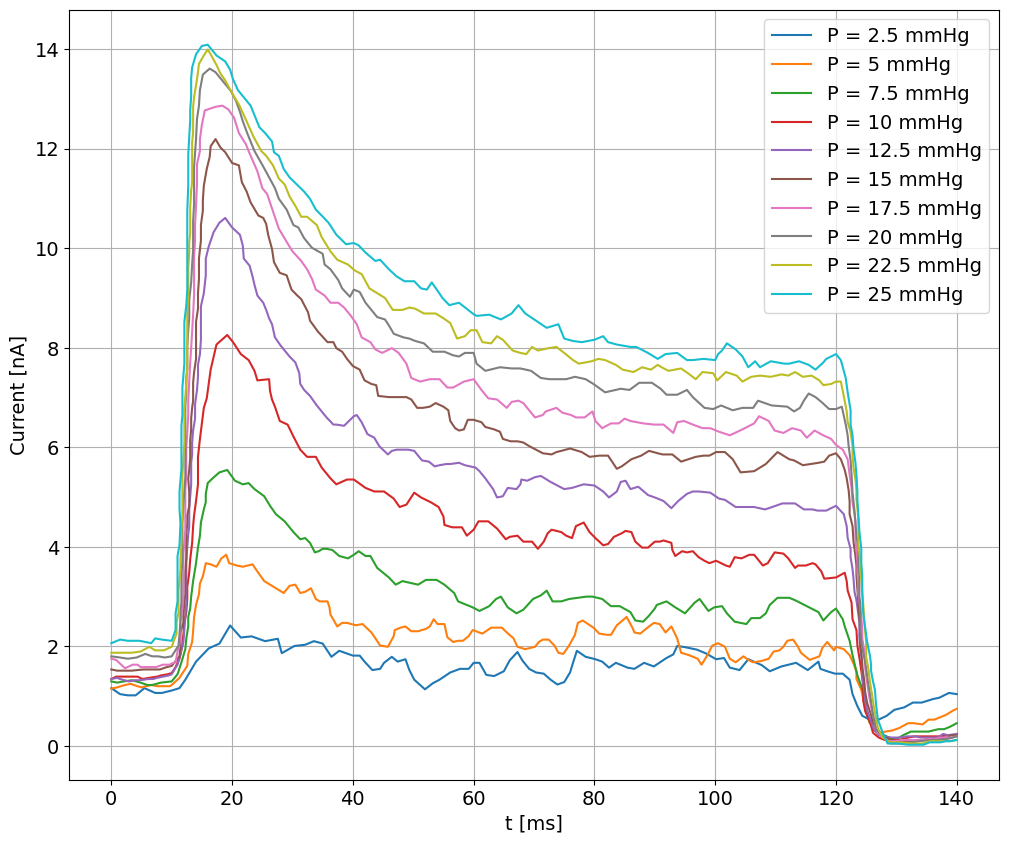

In [12]:
# Look at what the data I extracted look like
fig, ax= plt.subplots(1,1, figsize= (12,10))
for idx, value in enumerate(P_arr_str):
    plt.plot(I_data[value].x, I_data[value].y, label='P = ' + value + " mmHg")
plt.xlabel("t [ms]")
plt.ylabel("Current [nA]")
plt.grid()
plt.legend(loc='upper right');

## 1.2. Compute the conductance:


In [13]:
#Fitted parameters from Voltage fitting

Am    =    2.756769e-02 
Vmm   =    7.704963e+01
b1m   =    -2.440201e+01 
b2m   =    4.802552e+01 
c1m   =    -1.712336e-01 
c2m    =   4.493341e-02 
d1m     =  4.181831e-03 
d2m     =  4.526902e-03 
g_bar  =    8.256491e-02 

In [14]:
V_amp = np.arange(-100,120,20)
V_amp_str = [str(elem) for elem in V_amp]

In [15]:
g_data ={} 
for idx, value in enumerate(P_arr_str):
    g_data[value] = (I_data[value].y/(V_hold-E_k)).to_frame().join(I_data[value].x)

In [16]:
g_data_on = {}
t_on = 10.1
t_off = 120
for idx, value in enumerate(P_arr_str):
    g_data_on[value] = (I_data[value][(I_data[value].x>=t_on) & (I_data[value].x <= t_off)].y/(V_hold-E_k)).to_frame().join(I_data[value].x)

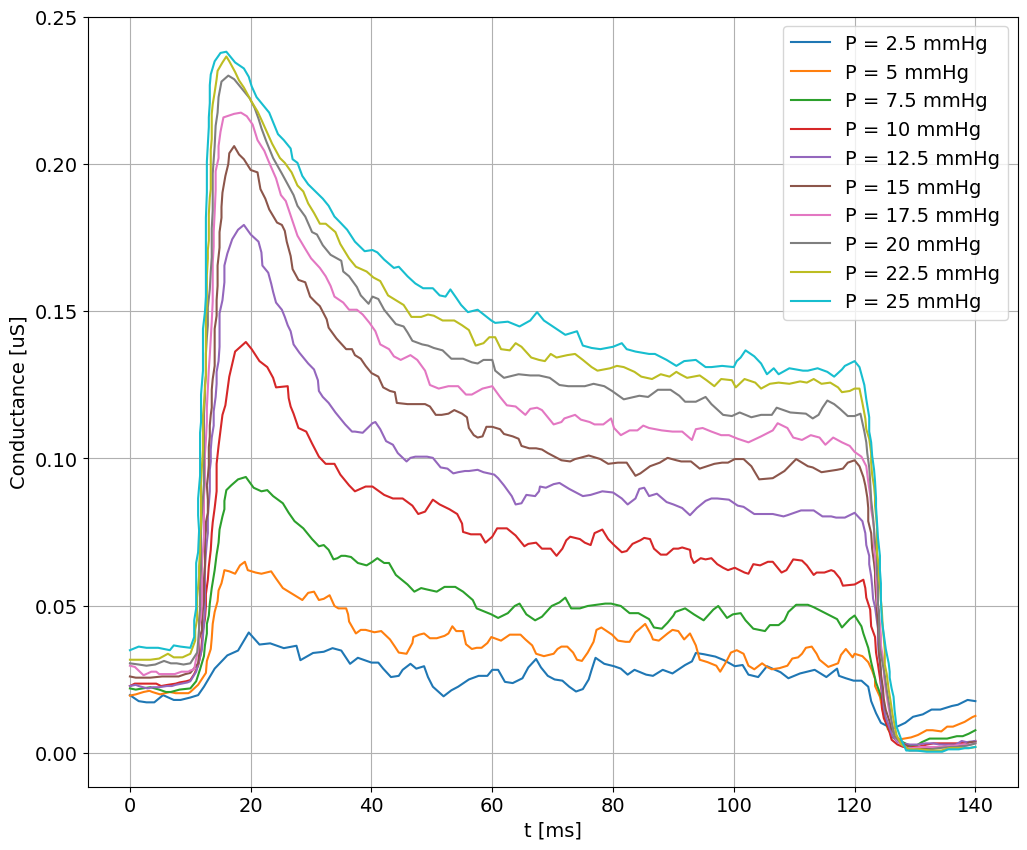

In [17]:
# Look at what the computed conductances look like
fig, ax= plt.subplots(1,1, figsize= (12,10))

for idx, value in enumerate(P_arr_str):
    plt.plot(g_data[value].x, g_data[value].y, label='P = ' + value + " mmHg")
    
plt.xlabel("t [ms]")
plt.ylabel("Conductance [uS]")
plt.grid()
plt.legend(loc='upper right');

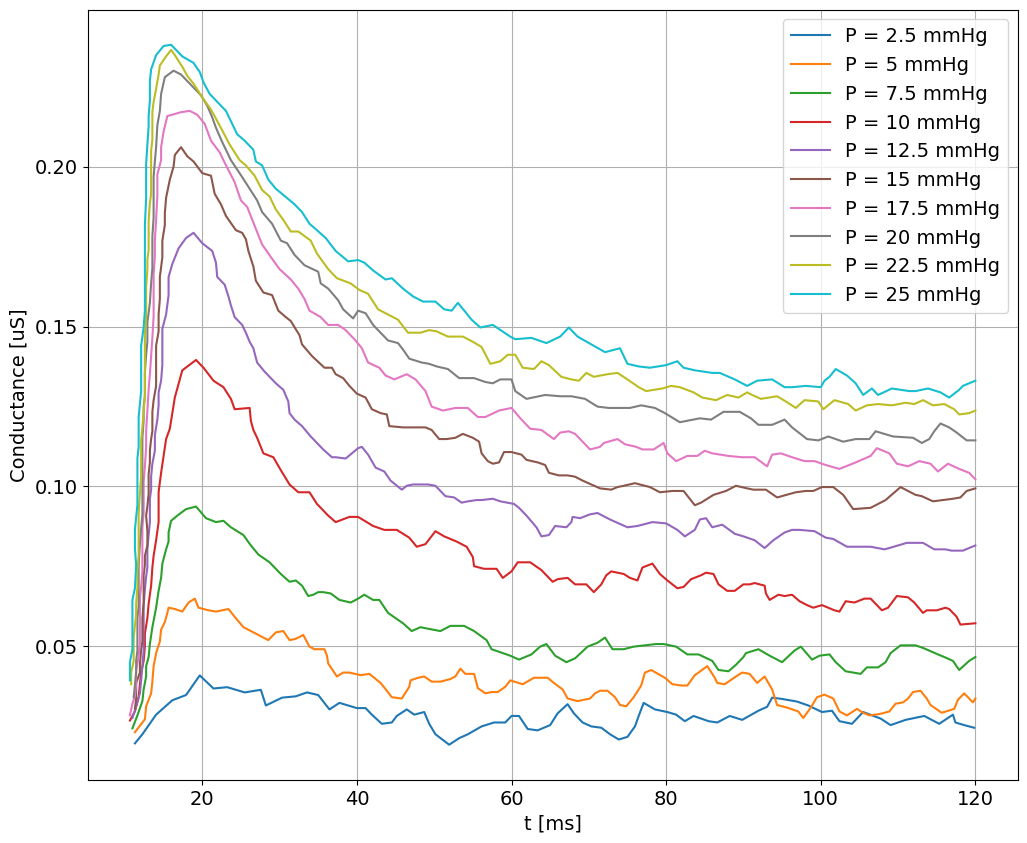

In [18]:
# Look at what the computed conductances (pressure on) look like
fig, ax= plt.subplots(1,1, figsize= (12,10))

for idx, value in enumerate(P_arr_str):
    plt.plot(g_data_on[value].x, g_data_on[value].y, label='P = ' + value + " mmHg")
    
plt.xlabel("t [ms]")
plt.ylabel("Conductance [uS]")
plt.grid()
plt.legend(loc='upper right');

## 1.3. Fitting with h0 = 1/2


In [21]:
#Define the model with symfit
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9 = variables('x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9')
gamma, delta_S, C, D, Ah, density, z1, z2 = parameters('gamma, delta_S, C, D, Ah, density, z1, z2')

alpham = []
betam = []
alphah = []
betah = []
m_inf = []
tau_m = []
h_inf = []
tau_h = []

density.min = 1
density.max = 150

gamma.min = 0
gamma.max = 1

delta_S.min = 0
delta_S.max = 200

C.min = -500
C.max = 500

D.min = -500
D.max = 500

Ah.min= 0.0001
Ah.max= 0.1

z1. min = -10000 
z1. max = 10000

z2. min = -10000 
z2. max = 10000

h0 = 1/2

V_m0 = 0
alpham0 = (Am*exp(-(b1m*(V_m0-Vmm) + c1m*(V_m0-Vmm)**2 + d1m*(V_m0-Vmm)**3)/(R*T)))
betam0 = (Am*exp(-(b2m*(V_m0-Vmm) + c2m*(V_m0-Vmm)**2 + d2m*(V_m0-Vmm)**3)/(R*T)))

m0 = (alpham0)/(alpham0+betam0) 


m = []
h=[]
x = [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]



for i, value in enumerate(P_arr_str):
    
    Ps_mmHg = P_arr[i]
    Ps_PA = Ps_mmHg * 133.322 
    Z_15mmHg = displacement_solver(Ps_PA,a,k)
    R_curv = set_R_curv(Z_15mmHg)
    Ts = set_tension(R_curv,Ps_PA)

    alpham.append(Am*exp(-(b1m*(V_hold-Vmm) + c1m*(V_hold-Vmm)**2 + d1m*(V_hold-Vmm)**3 - gamma*cst.N_A*Ts*delta_S*10**(-20))/(R*T)))
    betam.append(Am*exp(-(b2m*(V_hold-Vmm) + c2m*(V_hold-Vmm)**2 + d2m*(V_hold-Vmm)**3 - (gamma-1)*cst.N_A*Ts*delta_S*10**(-20))/(R*T)))

    alphah.append(Ah*exp(-(z1 - C*cst.N_A*Ts*10**(-20))/(R*T)))
    betah.append(Ah*exp(-(z2 - D*cst.N_A*Ts*10**(-20))/(R*T)))

    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    h_inf.append(alphah[i]/(alphah[i]+betah[i]))
    tau_h.append(1/(alphah[i]+betah[i]))

    m.append(m_inf[i] - (m_inf[i] - m0)*exp(-(x[i]-t_on)/tau_m[i]))
    h.append(h_inf[i] - (h_inf[i] - h0)*exp(-(x[i]-t_on)/tau_h[i]))

model = Model({
    y0: density*g_bar*h[0]*(m[0]),
    y1: density*g_bar*h[1]*(m[1]),
    y2: density*g_bar*h[2]*(m[2]),
    y3: density*g_bar*h[3]*(m[3]),
    y4: density*g_bar*h[4]*(m[4]),
    y5: density*g_bar*h[5]*(m[5]),
    y6: density*g_bar*h[6]*(m[6]),
    y7: density*g_bar*h[7]*(m[7]),
    y8: density*g_bar*h[8]*(m[8]),
    y9: density*g_bar*h[9]*(m[9]),
})

In [22]:
fit = Fit(model, 
        x0 = g_data_on['2.5'].x.to_numpy(), y0 = g_data_on['2.5'].y.to_numpy(),
        x1 = g_data_on['5'].x.to_numpy(), y1 = g_data_on['5'].y.to_numpy(),
        x2 = g_data_on['7.5'].x.to_numpy(), y2 = g_data_on['7.5'].y.to_numpy(),
        x3 = g_data_on['10'].x.to_numpy(), y3 = g_data_on['10'].y.to_numpy(),
        x4 = g_data_on['12.5'].x.to_numpy(), y4 = g_data_on['12.5'].y.to_numpy(),
        x5 = g_data_on['15'].x.to_numpy(), y5 = g_data_on['15'].y.to_numpy(),
        x6 = g_data_on['17.5'].x.to_numpy(), y6 = g_data_on['17.5'].y.to_numpy(),
        x7 = g_data_on['20'].x.to_numpy(), y7 = g_data_on['20'].y.to_numpy(),
        x8 = g_data_on['22.5'].x.to_numpy(), y8 = g_data_on['22.5'].y.to_numpy(),
        x9 = g_data_on['25'].x.to_numpy(), y9 = g_data_on['25'].y.to_numpy(),
        minimizer= [DifferentialEvolution, LBFGSB])
fit_result = fit.execute(DifferentialEvolution={'popsize': 50, 'recombination': 0.9, 'workers':-1})

c:\Users\monoy\OneDrive - epfl.ch\MA4\TNE\Code\.venv\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [23]:
print(fit_result)


Parameter Value        Standard Deviation
Ah        4.674148e-02 7.619300e-01
C         -1.364244e+01 3.124974e+00
D         -2.935563e+01 2.439356e+00
delta_S   9.388517e+01 4.866525e+00
density   6.262061e+00 1.262240e-01
gamma     3.380466e-01 1.724491e-02
z1        2.878358e+03 4.041078e+04
z2        -2.642638e+03 4.041031e+04
Status message         CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations   425
Objective              <symfit.core.objectives.LeastSquares object at 0x000001D8876D30D0>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x000001D8876D3730>, <symfit.core.minimizers.LBFGSB object at 0x000001D8876D2E00>])

Goodness of fit qualifiers:
chi_squared            0.355078783476542
objective_value        0.177539391738271
r_squared              0.7530224854008108


In [24]:
y_fit = model(x0 = g_data_on['2.5'].x.to_numpy(), 
              x1 = g_data_on['5'].x.to_numpy(),
              x2 = g_data_on['7.5'].x.to_numpy(), 
              x3 = g_data_on['10'].x.to_numpy(), 
              x4 = g_data_on['12.5'].x.to_numpy(), 
              x5 = g_data_on['15'].x.to_numpy(), 
              x6 = g_data_on['17.5'].x.to_numpy(),
              x7 = g_data_on['20'].x.to_numpy(), 
              x8 = g_data_on['22.5'].x.to_numpy(),
              x9 = g_data_on['25'].x.to_numpy(),**fit_result.params)

Fit: 2.5 mmHg, with adjusted R2=-1.9318231010409512
Fit: 5 mmHg, with adjusted R2=0.08270917690835067
Fit: 7.5 mmHg, with adjusted R2=0.3041333394200896
Fit: 10 mmHg, with adjusted R2=0.7483612729269811
Fit: 12.5 mmHg, with adjusted R2=0.7318811285614506
Fit: 15 mmHg, with adjusted R2=0.7082510073579584
Fit: 17.5 mmHg, with adjusted R2=0.735706521511219
Fit: 20 mmHg, with adjusted R2=0.7377504060795202
Fit: 22.5 mmHg, with adjusted R2=0.7678846566029738
Fit: 25 mmHg, with adjusted R2=0.812265999882086


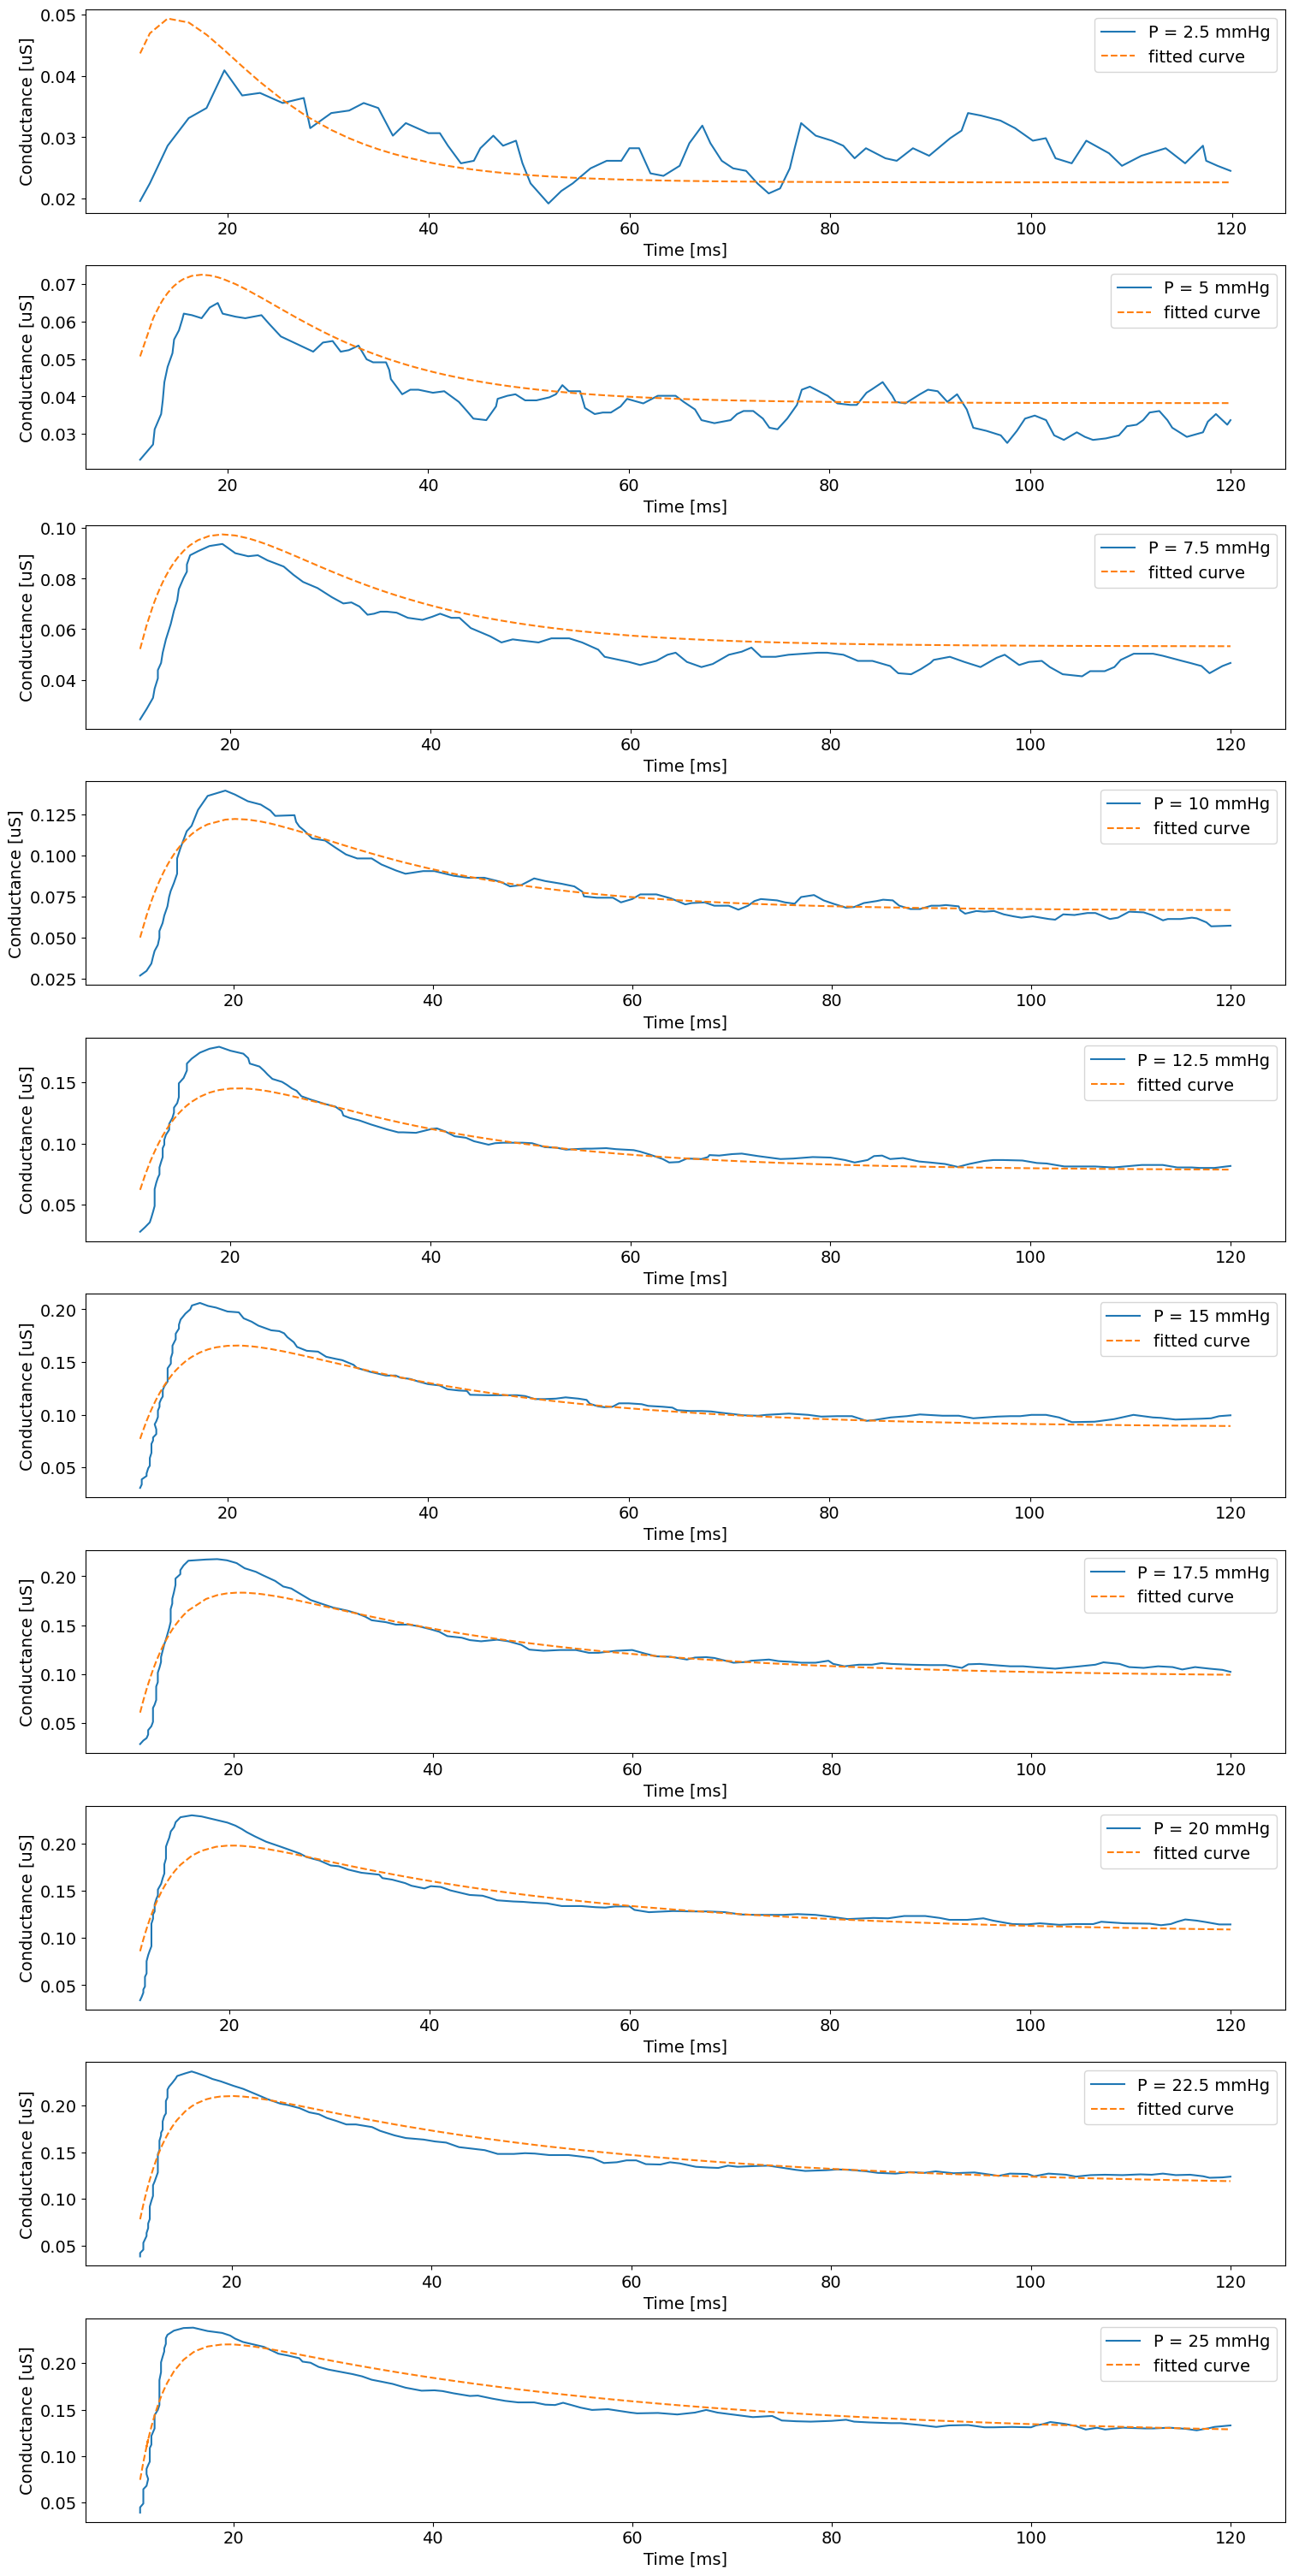

In [26]:
#plot the fitted curves

fig, ax= plt.subplots(10, 1, constrained_layout=True, figsize=(15, 30))

for idx, value in enumerate(P_arr_str):
    
    ax[idx].plot(g_data_on[value].x, g_data_on[value].y, label= 'P = ' + value + " mmHg")
    ax[idx].plot(g_data_on[value].x, y_fit[idx], '--', label = 'fitted curve')
    ax[idx].set_xlabel('Time [ms]')
    ax[idx].set_ylabel('Conductance [uS]')
    ax[idx].legend()

    print('Fit: {} mmHg, with adjusted R2={}'.format(value, adjusted_coeff_determ(g_data_on[value].y, y_fit[idx], len(g_data_on[value].x), 8)))

In [27]:
#Attribute fitted parameters
gamma = fit_result.params['gamma']
delta_S = fit_result.params['delta_S']
C = fit_result.params['C']
D = fit_result.params['D']
Ah = fit_result.params['Ah']
density =  fit_result.params['density']
z1 = fit_result.params['z1']
z2 = fit_result.params['z2']

In [28]:
#Calculate the state variables
alpham = []
betam = []
alphah = []
betah = []
m_inf = []
tau_m = []
h_inf = []
tau_h = []

for i in range(len(P_arr_str)):
    
    Ps_mmHg = P_arr[i]
    Ps_PA = Ps_mmHg * 133.322 
    Z_15mmHg = displacement_solver(Ps_PA,a,k)
    R_curv = set_R_curv(Z_15mmHg)
    Ts = set_tension(R_curv,Ps_PA)

    alpham.append(Am*exp(-(b1m*(V_hold-Vmm) + c1m*(V_hold-Vmm)**2 + d1m*(V_hold-Vmm)**3 - gamma*cst.N_A*Ts*delta_S*10**(-20))/(R*T)))
    betam.append(Am*exp(-(b2m*(V_hold-Vmm) + c2m*(V_hold-Vmm)**2 + d2m*(V_hold-Vmm)**3 - (gamma-1)*cst.N_A*Ts*delta_S*10**(-20))/(R*T)))

    alphah.append(Ah*exp(-(z1 - C*cst.N_A*Ts*10**(-20))/(R*T)))
    betah.append(Ah*exp(-(z2 - D*cst.N_A*Ts*10**(-20))/(R*T)))


    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    h_inf.append(alphah[i]/(alphah[i]+betah[i]))
    tau_h.append(1/(alphah[i]+betah[i]))


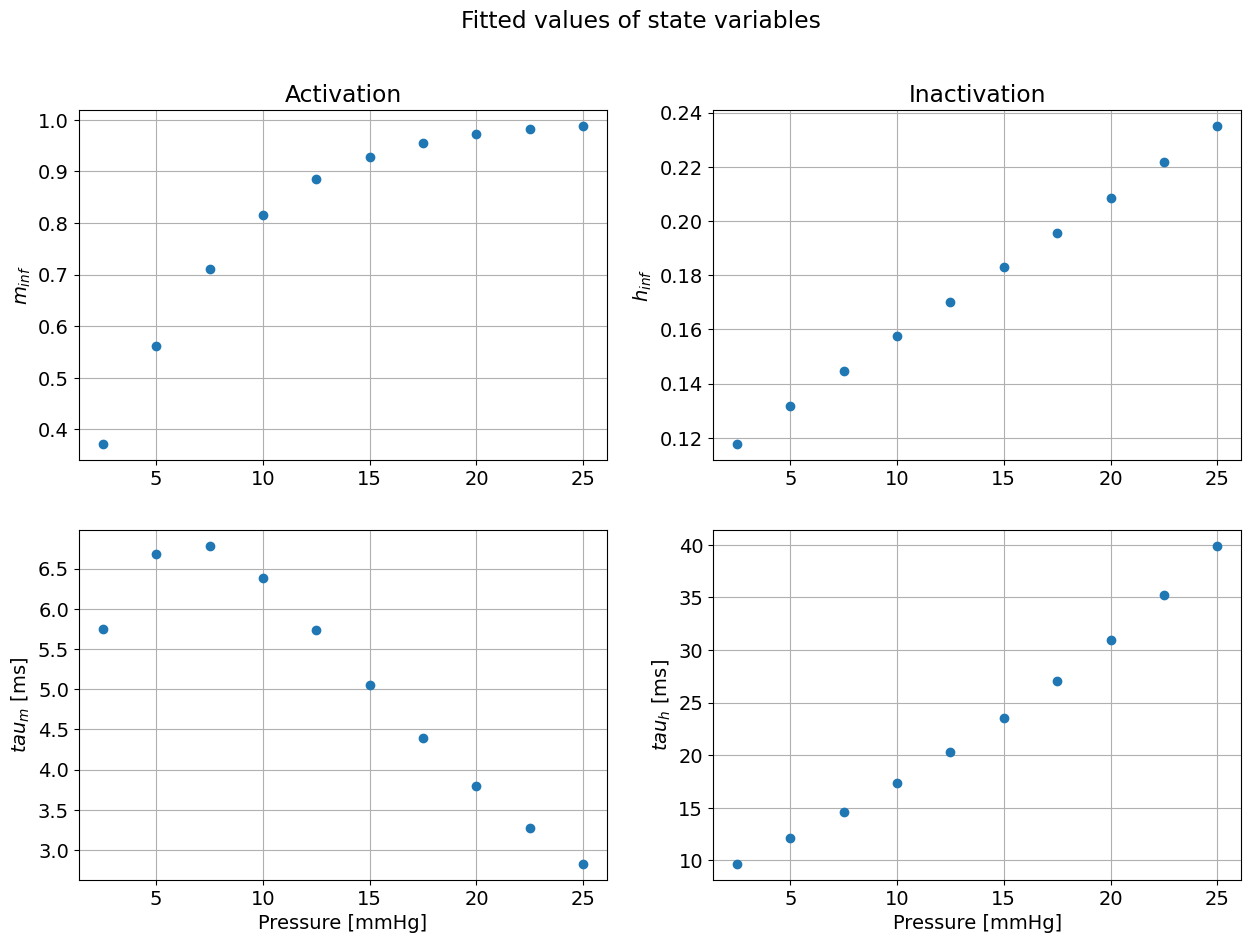

In [31]:
#Plot the state variables

fig, ax = plt.subplots(2,2,figsize= (15,10))
fig.suptitle('Fitted values of state variables')

ax[0][0].plot(P_arr, m_inf, 'o')
ax[0][0].set_ylabel('$m_{inf}$')
ax[0][0].grid()
ax[0][0].set_title('Activation')

ax[1][0].plot(P_arr, tau_m, 'o')
ax[1][0].set_ylabel('$tau_m$ [ms]')
ax[1][0].set_xlabel('Pressure [mmHg]')
ax[1][0].grid()

ax[0][1].plot(P_arr, h_inf, 'o')
ax[0][1].set_ylabel('$h_{inf}$')
ax[0][1].grid()
ax[0][1].set_title('Inactivation')

ax[1][1].plot(P_arr, tau_h, 'o')
ax[1][1].set_ylabel('$tau_h$ [ms]')
ax[1][1].set_xlabel('Pressure [mmHg]')
ax[1][1].grid()

## 1.4. Fitting with fitted h0


In [19]:
#Define the model with symfit
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9 = variables('x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9')
gamma, delta_S, C, D, Ah, density, z1, z2 = parameters('gamma, delta_S, C, D, Ah, density, z1, z2')

alpham = []
betam = []
alphah = []
betah = []
m_inf = []
tau_m = []
h_inf = []
tau_h = []

density.min = 1
density.max = 150

gamma.min = 0
gamma.max = 1

delta_S.min = 0
delta_S.max = 200

C.min = -500
C.max = 500

D.min = -500
D.max = 500

Ah.min= 0.0001
Ah.max= 0.1

z1. min = -10000 
z1. max = 10000

z2. min = -10000 
z2. max = 10000

alphah0 = (exp(-(z1)/(R*T)))
betah0 = (exp(-(z2)/(R*T)))

h0 = (alphah0/(alphah0+betah0))

V_m0 = 0
alpham0 = (Am*exp(-(b1m*(V_m0-Vmm) + c1m*(V_m0-Vmm)**2 + d1m*(V_m0-Vmm)**3)/(R*T)))
betam0 = (Am*exp(-(b2m*(V_m0-Vmm) + c2m*(V_m0-Vmm)**2 + d2m*(V_m0-Vmm)**3)/(R*T)))

m0 = (alpham0)/(alpham0+betam0) 


m = []
h=[]
x = [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]



for i, value in enumerate(P_arr_str):
    
    Ps_mmHg = P_arr[i]
    Ps_PA = Ps_mmHg * 133.322 
    Z_15mmHg = displacement_solver(Ps_PA,a,k)
    R_curv = set_R_curv(Z_15mmHg)
    Ts = set_tension(R_curv,Ps_PA)

    alpham.append(Am*exp(-(b1m*(V_hold-Vmm) + c1m*(V_hold-Vmm)**2 + d1m*(V_hold-Vmm)**3 - gamma*cst.N_A*Ts*delta_S*10**(-20))/(R*T)))
    betam.append(Am*exp(-(b2m*(V_hold-Vmm) + c2m*(V_hold-Vmm)**2 + d2m*(V_hold-Vmm)**3 - (gamma-1)*cst.N_A*Ts*delta_S*10**(-20))/(R*T)))

    alphah.append(Ah*exp(-(z1 - C*cst.N_A*Ts*10**(-20))/(R*T)))
    betah.append(Ah*exp(-(z2 - D*cst.N_A*Ts*10**(-20))/(R*T)))

    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    h_inf.append(alphah[i]/(alphah[i]+betah[i]))
    tau_h.append(1/(alphah[i]+betah[i]))

    m.append(m_inf[i] - (m_inf[i] - m0)*exp(-(x[i]-t_on)/tau_m[i]))
    h.append(h_inf[i] - (h_inf[i] - h0)*exp(-(x[i]-t_on)/tau_h[i]))

model = Model({
    y0: density*g_bar*h[0]*(m[0]),
    y1: density*g_bar*h[1]*(m[1]),
    y2: density*g_bar*h[2]*(m[2]),
    y3: density*g_bar*h[3]*(m[3]),
    y4: density*g_bar*h[4]*(m[4]),
    y5: density*g_bar*h[5]*(m[5]),
    y6: density*g_bar*h[6]*(m[6]),
    y7: density*g_bar*h[7]*(m[7]),
    y8: density*g_bar*h[8]*(m[8]),
    y9: density*g_bar*h[9]*(m[9]),
})

In [20]:
fit = Fit(model, 
        x0 = g_data_on['2.5'].x.to_numpy(), y0 = g_data_on['2.5'].y.to_numpy(),
        x1 = g_data_on['5'].x.to_numpy(), y1 = g_data_on['5'].y.to_numpy(),
        x2 = g_data_on['7.5'].x.to_numpy(), y2 = g_data_on['7.5'].y.to_numpy(),
        x3 = g_data_on['10'].x.to_numpy(), y3 = g_data_on['10'].y.to_numpy(),
        x4 = g_data_on['12.5'].x.to_numpy(), y4 = g_data_on['12.5'].y.to_numpy(),
        x5 = g_data_on['15'].x.to_numpy(), y5 = g_data_on['15'].y.to_numpy(),
        x6 = g_data_on['17.5'].x.to_numpy(), y6 = g_data_on['17.5'].y.to_numpy(),
        x7 = g_data_on['20'].x.to_numpy(), y7 = g_data_on['20'].y.to_numpy(),
        x8 = g_data_on['22.5'].x.to_numpy(), y8 = g_data_on['22.5'].y.to_numpy(),
        x9 = g_data_on['25'].x.to_numpy(), y9 = g_data_on['25'].y.to_numpy(),
        minimizer= [DifferentialEvolution, LBFGSB])
fit_result = fit.execute(DifferentialEvolution={'popsize': 50, 'recombination': 0.9, 'workers':-1})

c:\Users\monoy\OneDrive - epfl.ch\MA4\TNE\Code\.venv\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [21]:
print(fit_result)


Parameter Value        Standard Deviation
Ah        4.948322e-02 nan
C         -9.999272e+01 9.468083e+00
D         -3.867937e+01 5.679844e+00
delta_S   7.558841e+01 3.488164e+00
density   5.178670e+01 5.635253e+01
gamma     4.829157e-01 1.976884e-02
z1        6.641004e+03 nan
z2        -5.869676e+02 nan
Status message         CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations   418
Objective              <symfit.core.objectives.LeastSquares object at 0x00000247036D5FF0>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x00000247037A11B0>, <symfit.core.minimizers.LBFGSB object at 0x00000247037A2680>])

Goodness of fit qualifiers:
chi_squared            0.48068071401040335
objective_value        0.24034035700520168
r_squared              0.6656591900543783


c:\Users\monoy\OneDrive - epfl.ch\MA4\TNE\Code\.venv\lib\site-packages\symfit\core\fit_results.py:116: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.variance(param))


In [22]:
y_fit = model(x0 = g_data_on['2.5'].x.to_numpy(), 
              x1 = g_data_on['5'].x.to_numpy(),
              x2 = g_data_on['7.5'].x.to_numpy(), 
              x3 = g_data_on['10'].x.to_numpy(), 
              x4 = g_data_on['12.5'].x.to_numpy(), 
              x5 = g_data_on['15'].x.to_numpy(), 
              x6 = g_data_on['17.5'].x.to_numpy(),
              x7 = g_data_on['20'].x.to_numpy(), 
              x8 = g_data_on['22.5'].x.to_numpy(),
              x9 = g_data_on['25'].x.to_numpy(),**fit_result.params)

Fit: 2.5 mmHg, with adjusted R2=-6.60270553713592
Fit: 5 mmHg, with adjusted R2=-0.6380144508844359
Fit: 7.5 mmHg, with adjusted R2=0.12961358015843516
Fit: 10 mmHg, with adjusted R2=0.6268947583504512
Fit: 12.5 mmHg, with adjusted R2=0.6169179088478872
Fit: 15 mmHg, with adjusted R2=0.6331921283991755
Fit: 17.5 mmHg, with adjusted R2=0.6662819388778062
Fit: 20 mmHg, with adjusted R2=0.6656149882726402
Fit: 22.5 mmHg, with adjusted R2=0.6866578377117581
Fit: 25 mmHg, with adjusted R2=0.7301968785942188


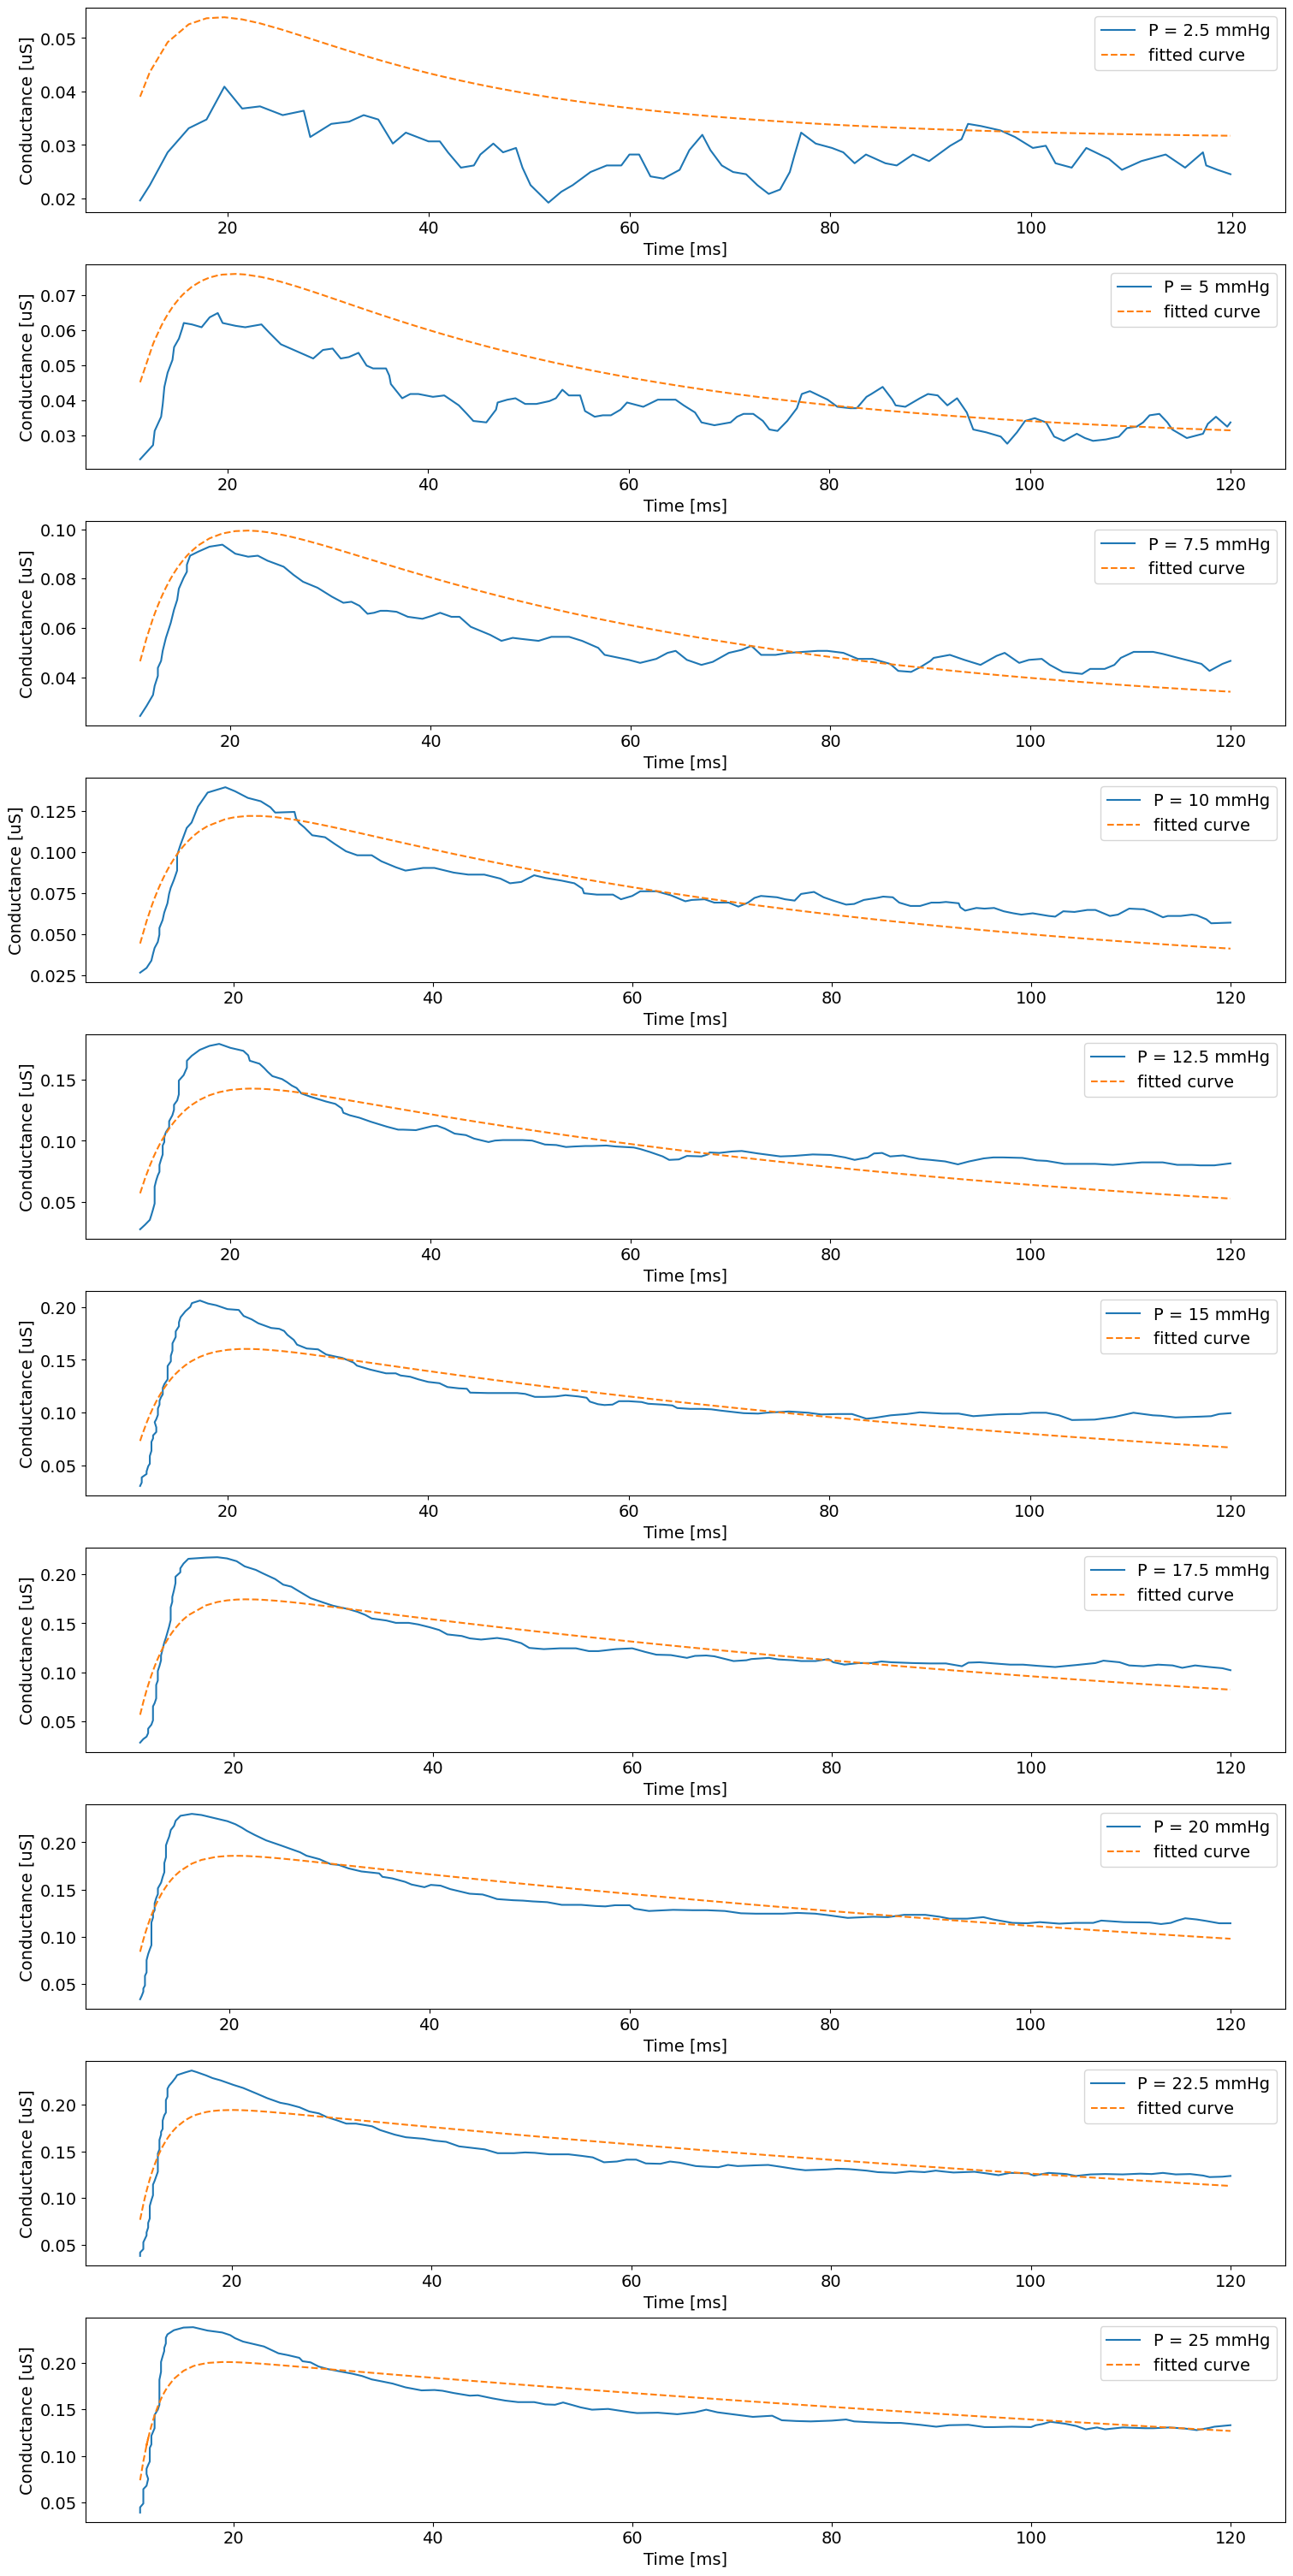

In [23]:
#Plot the fitted curves
fig, ax= plt.subplots(10, 1, constrained_layout=True, figsize=(15, 30))

for idx, value in enumerate(P_arr_str):
    
    ax[idx].plot(g_data_on[value].x, g_data_on[value].y, label= 'P = ' + value + " mmHg")
    ax[idx].plot(g_data_on[value].x, y_fit[idx], '--', label = 'fitted curve')
    ax[idx].set_xlabel('Time [ms]')
    ax[idx].set_ylabel('Conductance [uS]')
    ax[idx].legend()

    print('Fit: {} mmHg, with adjusted R2={}'.format(value, adjusted_coeff_determ(g_data_on[value].y, y_fit[idx], len(g_data_on[value].x), 8)))

In [24]:
gamma = fit_result.params['gamma']
delta_S = fit_result.params['delta_S']
C = fit_result.params['C']
D = fit_result.params['D']
Ah = fit_result.params['Ah']
density =  fit_result.params['density']
z1 = fit_result.params['z1']
z2 = fit_result.params['z2']

In [25]:
#Calculate the state variables
alpham = []
betam = []
alphah = []
betah = []
m_inf = []
tau_m = []
h_inf = []
tau_h = []

for i in range(len(P_arr_str)):
    
    Ps_mmHg = P_arr[i]
    Ps_PA = Ps_mmHg * 133.322 
    Z_15mmHg = displacement_solver(Ps_PA,a,k)
    R_curv = set_R_curv(Z_15mmHg)
    Ts = set_tension(R_curv,Ps_PA)

    alpham.append(Am*exp(-(b1m*(V_hold-Vmm) + c1m*(V_hold-Vmm)**2 + d1m*(V_hold-Vmm)**3 - gamma*cst.N_A*Ts*delta_S*10**(-20))/(R*T)))
    betam.append(Am*exp(-(b2m*(V_hold-Vmm) + c2m*(V_hold-Vmm)**2 + d2m*(V_hold-Vmm)**3 - (gamma-1)*cst.N_A*Ts*delta_S*10**(-20))/(R*T)))

    alphah.append(Ah*exp(-(z1 - C*cst.N_A*Ts*10**(-20))/(R*T)))
    betah.append(Ah*exp(-(z2 - D*cst.N_A*Ts*10**(-20))/(R*T)))


    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    h_inf.append(alphah[i]/(alphah[i]+betah[i]))
    tau_h.append(1/(alphah[i]+betah[i]))


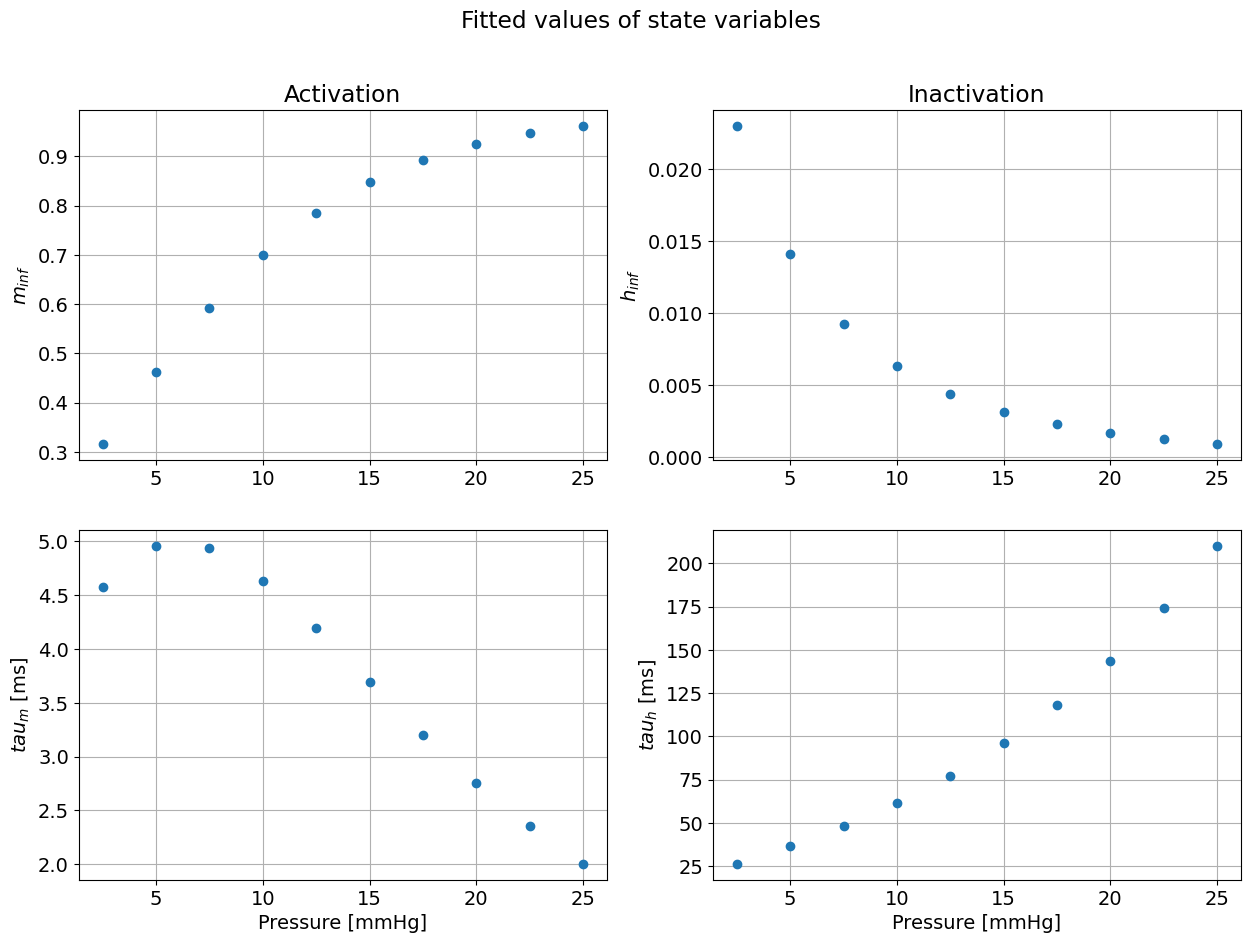

In [26]:
#Plot the state variables
fig, ax = plt.subplots(2,2,figsize= (15,10))
fig.suptitle('Fitted values of state variables')

ax[0][0].plot(P_arr, m_inf, 'o')
ax[0][0].set_ylabel('$m_{inf}$')
ax[0][0].grid()
ax[0][0].set_title('Activation')

ax[1][0].plot(P_arr, tau_m, 'o')
ax[1][0].set_ylabel('$tau_m$ [ms]')
ax[1][0].set_xlabel('Pressure [mmHg]')
ax[1][0].grid()

ax[0][1].plot(P_arr, h_inf, 'o')
ax[0][1].set_ylabel('$h_{inf}$')
ax[0][1].grid()
ax[0][1].set_title('Inactivation')

ax[1][1].plot(P_arr, tau_h, 'o')
ax[1][1].set_ylabel('$tau_h$ [ms]')
ax[1][1].set_xlabel('Pressure [mmHg]')
ax[1][1].grid()